In [9]:
# --- Standard Library ---
import sys
import os

# We set the path relative to all the root directory of the project
project_root = '/d/hpc/projects/FRI/jf73497/aimi-project/'
if project_root not in sys.path:
    sys.path.insert(0, project_root)


import random
import time
import yaml

# --- Third-Party Libraries ---
import numpy as np
import torch
from tqdm import tqdm
from matplotlib import pyplot as plt
from termcolor import colored
from scipy.ndimage import (
    binary_closing,
    binary_opening,
    binary_dilation,
    binary_erosion,
    generate_binary_structure
)

# --- Local Imports ---

from src.utils.competition_metric import ULS23_evaluator

# print(os.getcwd())
# sys.path.append("../../../nnUNet")

from nnunetv2.inference.predict_from_raw_data import nnUNetPredictor

import nnunetv2


# import os
import torch
from torch.utils.data import Dataset, DataLoader
import SimpleITK as sitk
import numpy as np
from glob import glob

from matplotlib import pyplot as plt
import matplotlib

In [10]:
print(torch.cuda.is_available())

True


In [11]:
def test_time_dilation(input_tensor):
    # Convert to NumPy and squeeze batch and channel dimensions
    volume = input_tensor.squeeze().cpu().numpy()
    
    # Apply binary dilation
    dilated = binary_dilation(volume, structure=np.ones((3, 3, 3)))

    return dilated.astype(np.uint8)

def test_time_2xdilation(input_tensor):
    volume = input_tensor.squeeze().cpu().numpy()
    
    # Apply binary dilation twice
    dilated = binary_dilation(volume, structure=np.ones((3, 3, 3)))
    dilated = binary_dilation(dilated, structure=np.ones((3, 3, 3)))

    return dilated.astype(np.uint8)

def test_time_opening(input_tensor):
    volume = input_tensor.squeeze().cpu().numpy()
    
    # Apply binary opening: erosion followed by dilation
    opened = binary_erosion(volume, structure=np.ones((3, 3, 3)))
    opened = binary_dilation(opened, structure=np.ones((3, 3, 3)))

    return opened.astype(np.uint8)

def test_time_closing(input_tensor):
    volume = input_tensor.squeeze().cpu().numpy()
    
    # Apply binary closing: dilation followed by erosion
    closed = binary_dilation(volume, structure=np.ones((3, 3, 3)))
    closed = binary_erosion(closed, structure=np.ones((3, 3, 3)))

    return closed.astype(np.uint8)

def test_time_shift(model, input_tensor, threshold=0.5):
    predictions = []

    device = model.device.type
    input_tensor = input_tensor.to(device)

    shifts = [
        (0, 0, 0),
        (5, 0, 0), 
        # (-5, 0, 0),
        # (0, 5, 0), 
        (0, -5, 0),
        # (0, 0, 5), 
        (0, 0, -5),
    ]

    with torch.no_grad():
        for dz, dx, dy in shifts:
            augmented = input_tensor.clone()

            # Shift
            augmented = torch.roll(augmented, shifts=(dz, dx, dy), dims=(1, 2, 3))

            # Model inference
            logits = model.predict_logits_from_preprocessed_data(input_tensor).unsqueeze(0)[:, 1:, ...]
            predicted = torch.sigmoid(logits)
            pred = predicted > threshold

            # Undo shift
            pred = torch.roll(pred, shifts=(-dz, -dx, -dy), dims=(1, 2, 3))
            predictions.append(pred.float())

    avg_prediction = torch.stack(predictions).mean(dim=0, keepdims=True)

    # --- Morphological smoothing ---
    # Convert to NumPy for processing
    pred_np = avg_prediction.squeeze().cpu().numpy()

    # Binarize
    binary_pred = pred_np > threshold
    return binary_pred

In [12]:
class NiiSliceDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform

        # List all image slices
        self.image_paths = sorted(glob(os.path.join(images_dir, "MIX_*_*.nii.gz")))
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]

        # Extract ID, e.g., MIX_00001_0000.nii.gz -> MIX_00001
        basename = os.path.basename(image_path)
        id_part = "_".join(basename.split("_")[:2])  # MIX_00001

        label_path = os.path.join(self.labels_dir, f"{id_part}.nii.gz")

        # Read image slice (single slice)
        image_itk = sitk.ReadImage(image_path)
        image = sitk.GetArrayFromImage(image_itk).astype(np.float32)

        # Read full label volume
        label_itk = sitk.ReadImage(label_path)
        label = sitk.GetArrayFromImage(label_itk).astype(np.int64)

        if self.transform:
            image, label = self.transform(image, label)

        # Convert to torch tensors
        image_tensor = torch.from_numpy(image) 
        label_tensor = torch.from_numpy(label) 

        return image_tensor, label_tensor

In [5]:
evaluator = ULS23_evaluator()

##################################################################################################
def seed_everything(seed) -> None:
    # seed = config["training_parameters"]["seed"]
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

performance_data = {
    "nnunet": {
        "dilation": [],
        "2xdilation": [],
        "opening": [],
        "closing": [],
        "shift": [],
        "original": [],
    }
}

def _run_eval(model, val_dataloader) -> None:
    """_summary_"""
    # Tell wandb to watch the model and optimizer values

    print("[info] -- Starting model evaluation")

    # Initialize the training loss for the current Epoch
    original_dice_total = 0.0
    original_uls_metric_total = 0.0
    dilated_uls_metric_total = 0.0
    dilatedx2_uls_metric_total = 0.0
    opening_uls_metric_total = 0.0
    closing_uls_metric_total = 0.0
    shift_uls_metric_total = 0.0


    ULS_per_threshold = [0.0]*9
    thresholds = np.linspace(0.1, 0.9, 9)
    

    # DATA IS 1x1x64x128x128, NO SPACINGS USED
    with torch.no_grad():
        for index, (data, labels) in enumerate(tqdm(val_dataloader)):

            logits = model.predict_logits_from_preprocessed_data(data).unsqueeze(0)[:, 1:, ...]
            predicted = torch.sigmoid(logits)

            for i, threshold in enumerate(thresholds):
                y_pred = predicted > threshold
                y_true = labels.unsqueeze(0)

                # SANITY CHECK
                # plt.imshow(y_pred[0, 0, 32])
                # plt.show()

                ULS_per_threshold[i] += evaluator.ULS_score_metric(y_pred, y_true)

    ULS_per_threshold = np.array(ULS_per_threshold)/float(index + 1)
    best_index = np.argmax(ULS_per_threshold)
    best_threshold = thresholds[best_index]

    print(ULS_per_threshold, best_threshold)


    # set epoch to shift data order each epoch
    # self.val_dataloader.sampler.set_epoch(self.current_epoch)
    with torch.no_grad():
        for index, (data, labels) in enumerate(tqdm(val_dataloader)):

            logits = model.predict_logits_from_preprocessed_data(data).unsqueeze(0)[:, 1:, ...]
            predicted = torch.sigmoid(logits)
            y_pred = predicted > best_threshold
            y_true = labels.unsqueeze(0)

            original_uls_metric_total += evaluator.ULS_score_metric(y_pred, y_true)
            performance_data["nnunet"]["original"].append(original_uls_metric_total.item())
            # print(f"Orgi ULS: {original_uls_metric}")

            # Test-time dilation
            dilated_pred = test_time_dilation(y_pred.float())
            dilated_uls_metric_total += evaluator.ULS_score_metric(
                torch.tensor(dilated_pred).unsqueeze(0).unsqueeze(0).to(y_true.device),
                y_true,
            )
            performance_data["nnunet"]["dilation"].append(dilated_uls_metric_total.item())

            # Test-time 2x dilation
            dilatedx2_pred = test_time_2xdilation(y_pred.float())
            dilatedx2_uls_metric_total += evaluator.ULS_score_metric(
                torch.tensor(dilatedx2_pred).unsqueeze(0).unsqueeze(0).to(y_true.device),
                y_true,
            )
            performance_data["nnunet"]["2xdilation"].append(dilatedx2_uls_metric_total.item())

            # Test-time opening
            opened_pred = test_time_opening(y_pred.float())
            opening_uls_metric_total += evaluator.ULS_score_metric(
                torch.tensor(opened_pred).unsqueeze(0).unsqueeze(0).to(y_true.device),
                y_true,
            )
            performance_data["nnunet"]["opening"].append(opening_uls_metric_total.item())

            # Test-time closing
            closed_pred = test_time_closing(y_pred.float())
            closing_uls_metric_total += evaluator.ULS_score_metric(
                torch.tensor(closed_pred).unsqueeze(0).unsqueeze(0).to(y_true.device),
                y_true,
            )
            performance_data["nnunet"]["closing"].append(closing_uls_metric_total.item())

            # Test-time shift
            shifted_pred = test_time_shift(model, data, threshold=best_threshold)
            shift_uls_metric_total += evaluator.ULS_score_metric(
                torch.tensor(shifted_pred).unsqueeze(0).unsqueeze(0).to(y_true.device),
                y_true,
            )
            performance_data["nnunet"]["shift"].append(shift_uls_metric_total.item())

    # Average across batches
    divisor = float(index + 1)
    original_uls_metric_total /= divisor
    dilated_uls_metric_total /= divisor
    dilatedx2_uls_metric_total /= divisor
    opening_uls_metric_total /= divisor
    closing_uls_metric_total /= divisor
    shift_uls_metric_total /= divisor

    original_std = np.std(performance_data["nnunet"]["original"])
    dilated_std = np.std(performance_data["nnunet"]["dilation"])
    dilatedx2_std = np.std(performance_data["nnunet"]["2xdilation"])
    opening_std = np.std(performance_data["nnunet"]["opening"])
    closing_std = np.std(performance_data["nnunet"]["closing"])
    shift_std = np.std(performance_data["nnunet"]["shift"])


    # Print metrics
    print(
        f"Original ULS: {colored(f'{original_uls_metric_total:.5f}', 'green')} ± {original_std:.5f} | "
        f"Dilated: {colored(f'{dilated_uls_metric_total:.5f}', 'cyan')} ± {dilated_std:.5f} | "
        f"2x Dilated: {colored(f'{dilatedx2_uls_metric_total:.5f}', 'cyan')} ± {dilatedx2_std:.5f} | "
        f"Opening: {colored(f'{opening_uls_metric_total:.5f}', 'cyan')} ± {opening_std:.5f} | "
        f"Closing: {colored(f'{closing_uls_metric_total:.5f}', 'cyan')} ± {closing_std:.5f} | "
        f"Shifted: {colored(f'{shift_uls_metric_total:.5f}', 'cyan')} ± {shift_std:.5f}"
    )

    return ULS_per_threshold



In [17]:
# set seed
seed_everything(42)


def load_model(path, folds=[0]):
    start_model_load_time = time.time()
    
    # Set up the nnUNetPredictor
    predictor = nnUNetPredictor(
        tile_step_size=0.5,
        use_gaussian=True,
        use_mirroring=False, # False is faster but less accurate
        device=torch.device(type='cuda', index=0),
        verbose=False,
        verbose_preprocessing=False,
        allow_tqdm=False
    )
    # Initialize the network architecture, loads the checkpoint
    predictor.initialize_from_trained_model_folder(
        path, # Path always relative to /opt/ml/model/
        use_folds=folds,
        checkpoint_name="checkpoint_best.pth",
    )
    end_model_load_time = time.time()
    print(f"Model loading runtime: {end_model_load_time - start_model_load_time}s")
    return predictor

model_path = "/d/hpc/home/jf73497/projects/aimi-project-data/Dataset001_MIX/nnUNetTrainer_ULS_400_QuarterLR__nnUNetResEncUNetMPlans__3d_fullres"
predictor = load_model(model_path, ("all"))


images_dir = "../aimi-project-data/raw/Dataset001_MIX/imagesTs"
labels_dir = "../aimi-project-data/raw/Dataset001_MIX/labelsTs"

dataset = NiiSliceDataset(images_dir, labels_dir)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

print("[info] -- Running evaluation only.")
ULS_per_threshold = _run_eval(predictor, dataloader)

Model loading runtime: 3.8358871936798096s
[info] -- Running evaluation only.
[info] -- Starting model evaluation


100%|██████████| 1443/1443 [1:17:45<00:00,  3.23s/it]  


[0.53314828 0.54031208 0.54274256 0.54383135 0.54398854 0.54336488
 0.54178021 0.53655763 0.52012585] 0.5


100%|██████████| 1443/1443 [1:27:20<00:00,  3.63s/it]

Original ULS: 0.54399 ± 227.76926 | Dilated: 0.43359 ± 183.43126 | 2x Dilated: 0.33686 ± 143.01668 | Opening: 0.49444 ± 204.75944 | Closing: 0.54425 ± 227.92482 | Shifted: 0.38016 ± 156.72916


In [18]:
print(ULS_per_threshold)

[0.53314828 0.54031208 0.54274256 0.54383135 0.54398854 0.54336488
 0.54178021 0.53655763 0.52012585]


In [32]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Example data (replace with your actual data)
thresholds = np.linspace(0.1, 0.9, 9)

# Set seaborn style
sns.set_theme(style="whitegrid", context="talk")


# #0D92F4, #C62E2E

# Create the plot
plt.figure(figsize=(15, 10))
sns.lineplot(x=thresholds, y=[0.55682154, 0.55853287, 0.5591937,  0.55975669, 0.56031297, 0.56064882, 0.56097877, 0.5611234, 0.56077012], 
             marker="o", linewidth=2.5, color="#F95454", label="SegFormer3D")
sns.lineplot(x=thresholds, y=[0.50172577, 0.5014836,  0.50113867, 0.50063356, 0.50024489, 0.49951492, 0.49866512, 0.49762634, 0.49459109], 
             marker="o", linewidth=2.5, color="#C62E2E", label="SegFormer3D_OS")
sns.lineplot(x=thresholds, y=ULS_per_threshold, marker="o", linewidth=2.5, color="#77CDFF", label="nnUNetv2_OS")
sns.lineplot(x=thresholds, y=[0.54725477, 0.55873257, 0.56346872, 0.56544667, 0.56639801, 0.56686143, 
                              0.56664409, 0.56499098, 0.55830482], 
             marker="o", linewidth=2.5, color="#0D92F4", label="nnUNetv2")

# Labels and title
plt.xlabel("Threshold", fontsize=14)
plt.ylabel("ULS Score", fontsize=14)
plt.title("ULS Score vs. Threshold", fontsize=16)
plt.xticks(thresholds, rotation=45)
# plt.ylim(0, 1)
plt.grid(True)
plt.legend()

# Show the plot
plt.tight_layout()
plt.savefig("src/evaluation_and_tta/threshold_optimization.pdf")
plt.show()

# Inference speed measurement

In [31]:
from time import perf_counter

def predict_with_threshold(model, data, threshold=0.5):

    """Predicts the segmentation mask using the model and applies a threshold.

    Args:
        model: The trained model for segmentation.
        data: Input data for prediction.
        threshold (float, optional): Threshold for binarizing predictions. Defaults to 0.5.

    Returns:
        torch.Tensor: Binarized predictions.
    """
    logits = model.predict_logits_from_preprocessed_data(data).unsqueeze(0)[:, 1:, ...]
    predicted = torch.sigmoid(logits)
    y_pred = predicted > threshold
    return y_pred.float()

time_data = {
    "nnunet":{
        "dilation": [],
        "2xdilation": [],
        "opening": [],
        "closing": [],
        "shift": [],
        "original": [],
    }
}

performance_data = {
    "nnunet": {
        "dilation": 0.44240,
        "2xdilation": 0.33654,
        "opening": 0.51330,
        "closing": 0.56719,
        "shift": 0.39253,
        "original": 0.56686,
    }
}

def benchmark_inference_speed(model, val_dataloader) -> None:
    with torch.no_grad():

        warmup_iterations = 10
        for index, (data, labels) in enumerate(tqdm(val_dataloader)):
            # get data ex: (data, target)

            _ = predict_with_threshold(model, data, threshold=0.5)

            if index >= warmup_iterations:
                break
        
        print("[info] -- Warmup completed. Starting inference speed measurement.")

        # After warmup, measure the inference speed
        measure_iterations = 100
        for index, (data, labels) in enumerate(tqdm(val_dataloader)):

            # print(f"Orgi ULS: {original_uls_metric}")

            # Original prediction
            start_original = perf_counter()
            y_pred = predict_with_threshold(model, data, threshold=0.5)
            end_original = perf_counter()
            original_time = end_original - start_original
            time_data["nnunet"]["original"].append(original_time)

            # Test-time dilation
            start_dilated = perf_counter()
            dilated_pred = test_time_dilation(predict_with_threshold(model, data, threshold=0.5))
            end_dilated = perf_counter()
            dilated_time = end_dilated - start_dilated
            time_data["nnunet"]["dilation"].append(dilated_time)


            # Test-time 2x dilation
            start_dilatedx2 = perf_counter()
            dilatedx2_pred = test_time_2xdilation(predict_with_threshold(model, data, threshold=0.5))
            end_dilatedx2 = perf_counter()
            dilatedx2_time = end_dilatedx2 - start_dilatedx2
            time_data["nnunet"]["2xdilation"].append(dilatedx2_time)

            # Test-time opening
            start_opened = perf_counter()
            opened_pred = test_time_opening(predict_with_threshold(model, data, threshold=0.5))
            end_opened = perf_counter()
            opened_time = end_opened - start_opened
            time_data["nnunet"]["opening"].append(opened_time)

            # Test-time closing
            start_closed = perf_counter()
            closed_pred = test_time_closing(predict_with_threshold(model, data, threshold=0.5))
            end_closed = perf_counter()
            closed_time = end_closed - start_closed
            time_data["nnunet"]["closing"].append(closed_time)

            # Test-time 
            start_shifted = perf_counter()
            shifted_pred = test_time_shift(model, data, threshold=0.5)
            end_shifted = perf_counter()
            shifted_time = end_shifted - start_shifted
            time_data["nnunet"]["shift"].append(shifted_time)

            if index >= measure_iterations:
                break


benchmark_inference_speed(predictor, dataloader)

# Average the times
avg_and_std_times = {key: [np.mean(times) if times else -1.0
                           , np.std(times) if times else -1.0] 
                     for key, times in time_data["nnunet"].items()}




import pandas as pd

# Prepare data for DataFrame
rows = []
for method, times in time_data["nnunet"].items():
    for t in times:
        rows.append({"Model": "nnUNet", "Method": method, "Time": t, "ULS": performance_data["nnunet"][method]})


csv_path = "./src/evaluation_and_tta/inference_times.csv"
# Read existing CSV if it exists
if os.path.exists(csv_path):
    df_existing = pd.read_csv(csv_path)
    # Append new rows to the existing DataFrame
    df_existing = pd.concat([df_existing, pd.DataFrame(rows)], ignore_index=True)
    df_times = df_existing
else:
    # Create a new DataFrame with the rows
    df_times = pd.DataFrame(rows)


df_times.to_csv(csv_path, index=False)


  1%|          | 10/1443 [00:04<10:21,  2.30it/s]


[info] -- Warmup completed. Starting inference speed measurement.


  7%|▋         | 100/1443 [05:33<1:14:37,  3.33s/it]


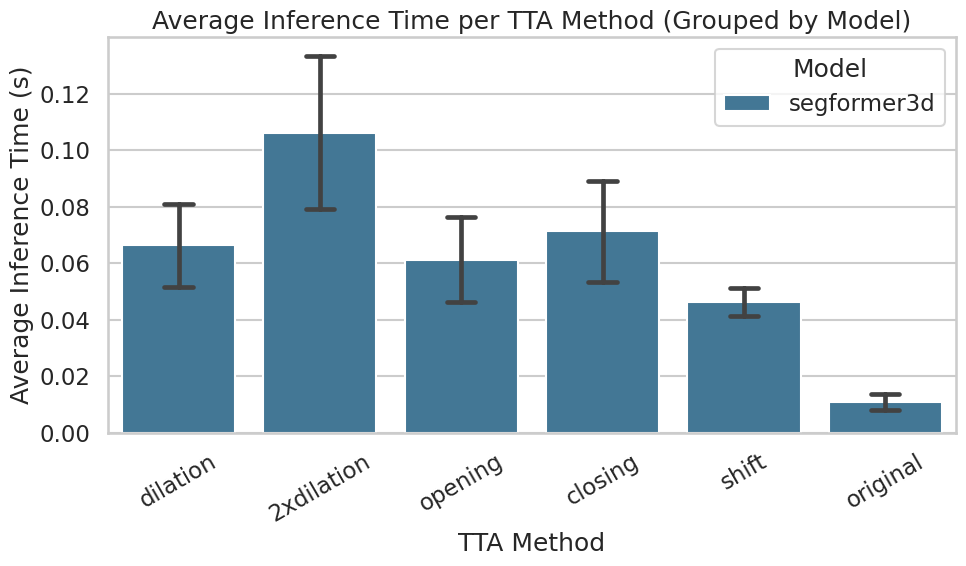

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
csv_path = "../../../../evaluation_and_tta/inference_times.csv"
df = pd.read_csv(csv_path)

# Plot grouped barplot
sns.set_theme(style="whitegrid", context="talk")
sns.set_palette("mako")
plt.figure(figsize=(10, 6))

ax = sns.barplot(
    df,
    x="Method",
    y="Time",
    errorbar="sd",
    capsize=0.2,
    palette="mako",
    hue="Model",
)

plt.ylabel("Average Inference Time (s)")
plt.xlabel("TTA Method")
plt.title("Average Inference Time per TTA Method (Grouped by Model)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.legend(title="Model")
plt.show()

# Model Size

In [34]:
def get_model_size(model):
    # Number of parameters
    num_params = sum(p.numel() for p in model.parameters())
    # Size in bytes (float32 = 4 bytes)
    param_size_bytes = sum(p.numel() * p.element_size() for p in model.parameters())
    param_size_mb = param_size_bytes / (1024 ** 2)
    print(f"Model parameters: {num_params:,}")
    print(f"Model size (MB): {param_size_mb:.2f}")
    return num_params, param_size_mb

# Example usage:
num_params, mb = get_model_size(predictor.network)
print(f"Model type: {type(predictor.network)}")
print(f"Model parameters: {num_params:,}")
print(f"Model size (MB): {mb:.2f}")

Model parameters: 101,940,170
Model size (MB): 388.87
Model type: <class 'dynamic_network_architectures.architectures.unet.ResidualEncoderUNet'>
Model parameters: 101,940,170
Model size (MB): 388.87
